# The `Well` object

Some preliminaries...

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.4.10.dev42+g3af8468.d20220207'

## Load a well from LAS

In the Quick Start guide you saw how to quickly create a Project from a well with:

```python
import welly
project = welly.from_las('path/to/well.las')
```

A `welly.Project` is a collection of `welly.Well` objects. But if you only have a single well, you may not need a Project; a Well object on its own will do. Then you could do this:

```python
well, = welly.from_las('path/to/well.las')
```

The presence of the comma after `well` unpacks the single item into the `welly` variable. (This is a Python trick, it's not a Welly thing.)

Alternatively, you can use the `Well.from_las()` method to load a well by passing a filename as a `str`. This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [35]:
from welly import Well

well = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-129.LAS')
well

Only engine='normal' can read wrapped files


Well(uwi: 'Long = 63* 45'24.460  W', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

The Location is not stored correctly, with latitude stored in Section and Longitude stored in Township. Also the UWI is wrong (at the top). We can fix all this by 'remapping' some fields. This is done with a dictionary that maps a well's field to its location in the LAS file. For example, we can use the Well field ('Kennetcook #2') to as the UWI in our well with a mapping like: `{'UWI': 'WELL'}`. We can remove a bad item such as the Section name, by mapping to `None`:

In [32]:
remap = {
    'UWI': 'WELL',
    'KB': 'EKB',
    'LATI': 'SECT',
    'LONG': 'TOWN',
    'SECT': None,
    'TOWN': None,
    'LOC': None
}

well = Well.from_las('data/P-129_out.LAS', remap=remap)
well

Only engine='normal' can read wrapped files


Well(uwi: 'Kennetcook #2', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

## Well header

Metadata about the well is stored in its `header` attribute:

In [19]:
well.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


### Important note

At present, the well's `header` contains a DataFrame with the entire LAS file header.

In a future release, only the well information from the **WELL** part of the file will be stored in the well's header. (The Params data goes into the `well.location` attribute, and the Curve data goes into Welly's `Curve` objects.)

## Well location

The well's `location` contains the location info from **PARAMS**, and will also store the well's 3D positional information, if available.

In [23]:
well.location

Location({'position': None, 'crs': CRS({}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '45.20 Deg N', 'longitude': '63.75 Deg W', 'datum': '', 'range': 'PD 176', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

The CRS for this well is missing; we can add one if we know it:

In [24]:
well.location.crs = welly.CRS.from_epsg(2038)

well.location

Location({'position': None, 'crs': CRS({'init': 'epsg:2038', 'no_defs': True}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '45.20 Deg N', 'longitude': '63.75 Deg W', 'datum': '', 'range': 'PD 176', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

Right now there's no position log — we need to load a deviation survey.

In [26]:
well.location.position

## Add deviation data to a well

Let's load another well:

In [28]:
import numpy as np
from welly import Well

well = Well.from_las('data/P-130_out.LAS')

In [29]:
dev = np.loadtxt('data/P-130_deviation_survey.csv', delimiter=',', skiprows=1)

The columns are MD, inclination, azimuth, and TVD.

In [30]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` assumes those are the columns, and computes a position log.

In [31]:
p.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [32]:
p.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.71237821e-02, 1.79999178e+01],
       [0.00000000e+00, 1.86748917e-01, 3.79994202e+01],
       [0.00000000e+00, 5.18340431e-01, 5.69962853e+01],
       [0.00000000e+00, 1.29577626e+00, 8.39850594e+01]])

In [33]:
p.location.trajectory()

array([[ 6.45933639e-01,  3.47023772e-01, -1.65395432e-02],
       [ 5.90396925e-01,  3.28218888e-01, -2.63643779e+00],
       [ 5.36457735e-01,  3.11968468e-01, -5.25632568e+00],
       ...,
       [-3.68094384e+00,  3.97484953e+01, -2.61112780e+03],
       [-3.68832058e+00,  3.96833189e+01, -2.61374906e+03],
       [-3.69619567e+00,  3.96172858e+01, -2.61637033e+03]])

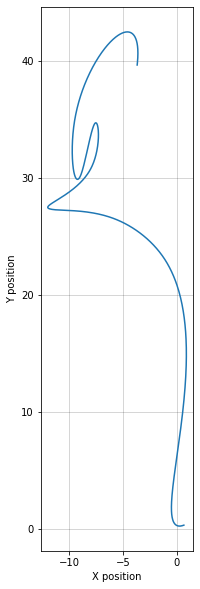

In [34]:
p.location.plot_plan()

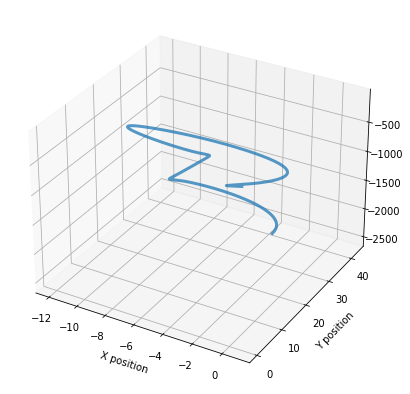

In [35]:
p.location.plot_3d()

For more about the `location` attribute, see the [Well_location](Well_location.ipynb) help.

## Quick plot

`welly` produces `matplotlib` plots easily... but they aren't all that pretty. You can pass in an Axes object as `ax`, and you can embellish the plots by adding more `matplotlib` commands.

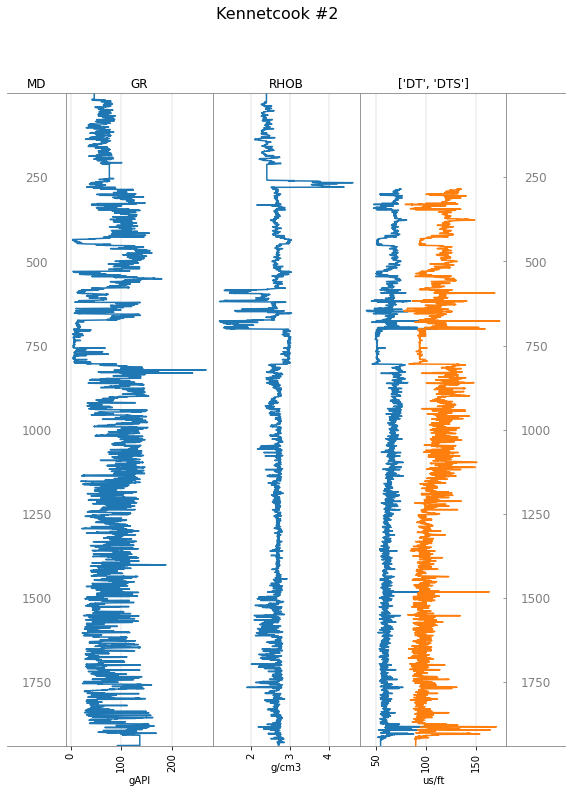

In [22]:
tracks = ['MD', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']

well.plot(tracks=tracks)

## Location and CRS

In [24]:
w.location

Location({'position': None, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '', 'longitude': '', 'datum': '', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'ekb': 94.8, 'egl': 90.3, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

## Export curves to data matrix

Make a NumPy array:

In [36]:
w.data_as_matrix()

array([[Curve(mnemonic=CALI, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=HCAL, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[2138]),
        Curve(mnemonic=PEF, units=, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DT, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10849]),
        Curve(mnemonic=DTS, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10849]),
        Curve(mnemonic=DPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DPHI_LIM, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DPHI_DOL, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=NPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=NPHI_LIM, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, co

## Export curves to pandas

Pandas is an optional dependency. You'll need it to make this work.

In [37]:
df = w.df()

In [38]:
df.head()

,CALI,HCAL,PEF,DT,DTS,DPHI_SAN,DPHI_LIM,DPHI_DOL,NPHI_SAN,NPHI_LIM,...,RLA1,RLA2,RXOZ,RXO_HRLT,RT_HRLT,RM_HRLT,DRHO,RHOB,GR,SP
DEPT,,,,,,,,,,,,,,,,,,,,,
1.0668,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.2192,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.3716,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.5240,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.6764,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125


<AxesSubplot:xlabel='DEPT'>

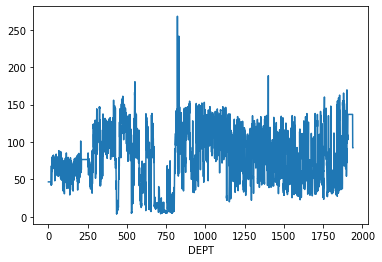

In [39]:
df.GR.plot()

This also gives us another path to getting a matrix:

In [40]:
w.df().values

array([[  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.        ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.9375    ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  74.25      ]])

You'll have to get depth separately:

In [41]:
w.df().index.values

array([1.0668000e+00, 1.2192000e+00, 1.3716000e+00, ..., 1.9388328e+03,
       1.9389852e+03, 1.9391376e+03])

To get the UWI of the well as well, e.g. if you want to combine multiple wells (maybe using `welly.Project.df()`):

In [42]:
df = w.df(uwi=True)

In [43]:
df.head()

CALI          HCAL          PEF  DT  \
UWI                     DEPT                                                  
Long = 63* 45'24.460  W 1.0668  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.2192  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.3716  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.5240  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.6764  2.4438154697  4.3912849426  3.586400032 NaN   

                                DTS      DPHI_SAN      DPHI_LIM      DPHI_DOL  \
UWI                     DEPT                                                    
Long = 63* 45'24.460  W 1.0668  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.2192  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.3716  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.5240  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.6764  NaN  0.1574800014  0.1984400004  0.2590999901   

                                    NPHI_SAN      NPHI_LIM  ...          RLA1  \
UWI                     DEPT                                ...                 
Long = 63* 45'24.460  W 1.0668  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.2192  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.3716  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.5240  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.6764  0.4650999904  0.3364700079  ...  0.0320999995   

                                        RLA2          RXOZ      RXO_HRLT  \
UWI                     DEPT                                               
Long = 63* 45'24.460  W 1.0668  0.0279399995  0.0576100014  0.0255800001   
                        1.2192  0.0279399995  0.0576100014  0.0255800001   
                        1.3716  0.0279399995  0.0576100014  0.0255800001   
                        1.5240  0.0279399995  0.0576100014  0.0255800001   
                        1.6764  0.0279399995  0.0576100014  0.0255800001   

                                     RT_HRLT       RM_HRLT          DRHO  \
UWI                     DEPT                                               
Long = 63* 45'24.460  W 1.0668  0.0255800001  0.0550099984  0.1942329407   
                        1.2192  0.0255800001  0.0550099984  0.1942329407   
                        1.3716  0.0255800001  0.0550099984  0.1942329407   
                        1.5240  0.0255800001  0.0550099984  0.1942329407   
                        1.6764  0.0255800001  0.0550099984  0.1942329407   

                                        RHOB           GR       SP  
UWI                     DEPT                                        
Long = 63* 45'24.460  W 1.0668  2.3901498318  46.69865036  120.125  
                        1.2192  2.3901498318  46.69865036  120.125  
                        1.3716  2.3901498318  46.69865036  120.125  
                        1.5240  2.3901498318  46.69865036  120.125  
                        1.6764  2.3901498318  46.69865036  120.125  

[5 rows x 24 columns]

### Pandas with an alias dictionary

In [44]:
alias

{'Gamma': ['GR', 'GAM', 'GRC', 'SGR', 'NGT'],
 'Density': ['RHOZ', 'RHOB', 'DEN', 'RHOZ'],
 'Sonic': ['DT', 'AC', 'DTP', 'DT4P'],
 'Caliper': ['CAL', 'CALI', 'CALS', 'C1'],
 'Porosity SS': ['NPSS', 'DPSS']}

In [48]:
keys = ['CALI', 'Gamma', 'Density', 'Sonic', 'RLA1']
w.df(keys=keys, alias=alias, rename_aliased=True).head()

,CALI,Gamma,Density,Sonic,RLA1
DEPT,,,,,
1.0668,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.2192,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.3716,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.5240,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.6764,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995


## Make an 'empty' well

In [2]:
w = welly.Well()

w.header  # is empty

,original_mnemonic,mnemonic,unit,value,descr,section


We can set the **UWI** and **name** of a well directly on the well object, but these are the only attributes of the well we can set in this way.

In [3]:
w.uwi = 'foo'
w.uwi

'foo'

In [4]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,UWI,UWI,None,foo,None,header


---

&copy; 2022 Agile Scientific, CC BY